In [39]:
# %pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import pygad

In [4]:
ds = pd.read_json("datasets/easy_dataset_1.json")
ds

,dataset_id,num_papers,num_reviewers,reviewer_capacity,min_reviews_per_paper,max_reviews_per_paper,preferences,friendships,authorship
0,Easy Dataset 1,5,5,3,3,5,"[3, 2, 1, 5, 3]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
1,Easy Dataset 1,5,5,3,3,5,"[5, 2, 4, 2, 2]","[0, 0, 1, 0, 0]","[0, 1, 0, 0, 0]"
2,Easy Dataset 1,5,5,3,3,5,"[4, 3, 1, 2, 4]","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]"
3,Easy Dataset 1,5,5,3,3,5,"[4, 2, 2, 1, 1]","[0, 0, 0, 0, 0]","[1, 1, 0, 0, 1]"
4,Easy Dataset 1,5,5,3,3,5,"[4, 3, 4, 1, 5]","[0, 0, 0, 0, 0]","[0, 0, 1, 1, 0]"


In [34]:
def extract_data(file_path):
    ds = pd.read_json(file_path)
    preferences = np.array([list(row) for row in ds["preferences"]])
    friendships = np.array([list(row) for row in ds["friendships"]])
    authorship = np.array([list(row) for row in ds["authorship"]])
    return  preferences, friendships, authorship


In [38]:
preferences, friendships, authorship = extract_data("datasets/easy_dataset_1.json")
# print(authorship)
# print(authorship.shape)

num_authors = authorship.shape[0]
num_papers = authorship.shape[1]
solution_matrix = np.zeros((num_authors, num_papers))

In [42]:
def fitness_function_impl(assignment, preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    # Total Preference Score
    preference_score = np.sum(assignment * preferences)

    # Capacity Violation
    capacity_violation = np.sum(np.maximum(0, np.sum(assignment, axis=1) - capacity))

    # Review Violations
    reviews_per_paper = np.sum(assignment, axis=0)
    review_violation = np.sum(np.maximum(0, min_reviews - reviews_per_paper)) + \
                       np.sum(np.maximum(0, reviews_per_paper - max_reviews))

    # Friendship Joint Review Violation
    friendship_violation = 0
    for i in range(len(friendships)):
        for j in range(len(friendships)):
            if friendships[i][j] == 1:
                # Penalize if both friends review the same paper
                friendship_violation += np.sum(assignment[i] * assignment[j])

    # Friends Reviewing Each Other's Papers
    friends_authorship_violation = 0
    num_reviewers, num_papers = assignment.shape
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            # Check if any of the reviewer's friends authored the paper
            for friend in range(num_reviewers):
                if friendships[reviewer][friend] == 1 and authorship[friend][paper] == 1:
                    # Penalize if the reviewer is assigned to the paper
                    friends_authorship_violation += assignment[reviewer][paper]

    # Authorship Violation
    authorship_violation = np.sum(assignment * authorship)

    # Weights for penalties
    w1, w2, w3, w4, w5 = 10, 10, 50, 50, 50

    # Fitness
    fitness = preference_score - (w1 * capacity_violation + w2 * review_violation +
                                   w3 * friendship_violation + w4 * friends_authorship_violation +
                                   w5 * authorship_violation)
    return fitness

In [48]:
capacity = ds["reviewer_capacity"][0]
min_reviews = ds["min_reviews_per_paper"][0]
max_reviews = ds["max_reviews_per_paper"][0]
num_reviewers, num_papers = preferences.shape
num_genes = num_reviewers * num_papers

def fitness_function(ga_instance, solution, solution_idx):
    # Reshape the 1D solution to a 2D assignment matrix
    assignment = solution.reshape((num_reviewers, num_papers))
    
    # Ensure binary values in the assignment matrix
    assignment = np.clip(assignment, 0, 1)

    # Calculate fitness using the provided fitness function
    return fitness_function_impl(
        assignment,
        preferences,
        capacity,
        min_reviews,
        max_reviews,
        friendships,
        authorship
    )

print(capacity)

3


In [49]:
def generate_random_solution(num_reviewers, num_papers, reviewer_capacity):
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    for reviewer in range(num_reviewers):
        # Randomly assign up to 'reviewer_capacity' papers to each reviewer
        papers_to_assign = np.random.choice(num_papers, reviewer_capacity, replace=False)
        solution[reviewer, papers_to_assign] = 1
    return solution

random_solution = generate_random_solution(num_reviewers, num_papers, capacity)
print("Random Solution Matrix:\n", random_solution)

Random Solution Matrix:
 [[1 0 1 0 1]
 [1 0 1 1 0]
 [0 1 1 1 0]
 [1 0 0 1 1]
 [1 0 1 0 1]]


In [50]:
ga_instance = pygad.GA(
    num_generations=100,              # Number of generations
    num_parents_mating=10,            # Number of parents mating
    fitness_func=fitness_function,    # Fitness function
    sol_per_pop=20,                   # Population size
    num_genes=num_genes,              # Number of genes (flattened assignment matrix)
    gene_type=int,                    # Gene type (binary)
    init_range_low=0,                 # Lower bound for gene values
    init_range_high=1,                # Upper bound for gene values
    parent_selection_type="tournament", # Parent selection method
    crossover_type="single_point",    # Crossover method
    mutation_type="random",           # Mutation method
    mutation_percent_genes=10         # Mutation rate
)

# Run the genetic algorithm
ga_instance.run()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best solution fitness: -150
Best Assignment Matrix:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


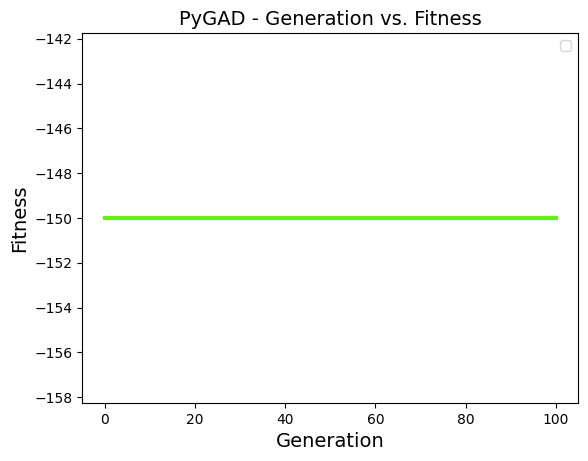

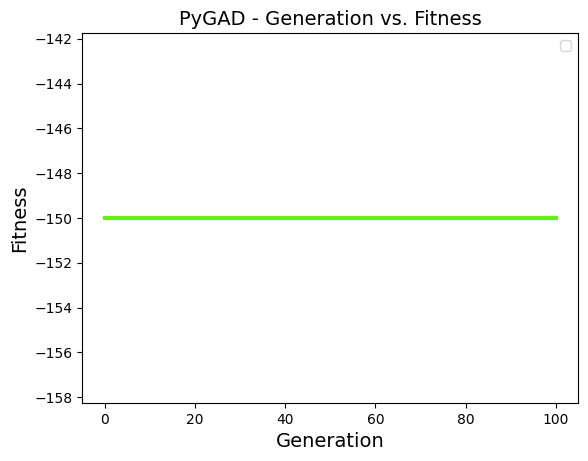

In [52]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best solution fitness:", solution_fitness)

# Reshape the solution into the assignment matrix
best_assignment = solution.reshape((num_reviewers, num_papers))
print("Best Assignment Matrix:\n", best_assignment)
ga_instance.plot_fitness()